In [125]:
!pip install edsnlp
!pip install altair
!pip install lifelines

# Exercise 3: Clinical notes and natural language processing


In this exercice we introduce an important new category of data, **clinical notes**, along with **eds-nlp** (see [doc](https://aphp.github.io/edsnlp)) a scientific library that facilitates the definition of NLP algorithms for French clinical texts.

The use case consists of validating/completing the drug table. Indeed, we fear that natively structured data on drugs are incomplete leading to patients being falsely included in the control cohort although they had a drug administred. We make the assumption that textual data contained in clinical notes are complete as it is well known that care professionals extensively use this format to record information.

In this exercice, we will :
1. Find drug administration for patients using NLP methods
2. Compare the Kaplan Meyer curves obtained using or not NLP algorithms to identify drugs.

We initialize the notebook by importing the following libraries:

In [126]:
import pandas as pd
import numpy as np

# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# For the computation of Kaplan-Meier estimates and log-rank tests
import lifelines

 # Table of content

# 1. Data Exploration

A fake dataset that mimics data coming from a clinical information system is made available in the */data* folder of this exercise.
<br>For this study, data has been extracted from the Clinical Data Warehouse on December 1st, 2025.
<br>The same data than in exercice 1 is imported

## 1.1 Data extracted from the Clinical Data Warehouse

Open the following files using the `pandas.read_pickle()` function :
  - *data/df_person.pkl* as `df_person`
  - *data/df_visit.pkl* as `df_visit`
  - *data/df_condition.pkl* as `df_cond`
  - *data/df_med.pkl* as `df_med`

In [127]:
# Patients
df_person = pd.read_pickle('data/df_person.pkl')
# Visits
df_visit = pd.read_pickle('data/df_visit.pkl')
# Diagnosis (condition)
df_cond = pd.read_pickle('data/df_condition.pkl')
# Medication
df_med = pd.read_pickle('data/df_med.pkl')

Create a dataframe `df_visit_med` that indicates which drug was administered for each visit.

TIP : LEFT JOIN `df_visit` and `df_med` on `visit_occurrence_id` using the `pandas.merge()` function (see [doc](https://pandas.pydata.org/docs/reference/api/pandas.merge.html))

In [128]:
df_visit_med = pd.merge(df_visit, df_med, on = 'visit_occurrence_id', how = 'left')

How many patients are in the study?
<br>We suppose deduplication has already been done.

In [129]:
print(f"We have {df_person.person_id.nunique()} unique patient ids in this dataset.")

We have 6000 unique patient ids in this dataset.


Make sure every patient only has only one visit and therefore one drug administration

TIPS : Count the number of patients in the dataset `df_visit_med` using `pandas.value_counts()` and check there is only one occurence of every patient.

In [130]:
df_value_count = df_visit_med.person_id.value_counts()
n_numerous = df_value_count[df_value_count > 1].size
print("{} patients have more than one visit".format(n_numerous))

0 patients have more than one visit


How many patients have had :
- drugA  administered ?
- drugB administered ?

TIP : Count the number of drugA and drugB administered in the dataset `df_visit_med` using `pandas.value_counts()`

In [131]:
count_drug = df_med.drug_source_value.value_counts()
print(f" {count_drug['drugA']} patients have had the drugA administered. \n{count_drug['drugB']} patients have had the drugB administered.")

 965 patients have had the drugA administered. 
1030 patients have had the drugB administered.


How many patients have had no drug administered according to the structured information?

In [132]:
df_person.person_id.nunique() - len(df_med)

print(f"{df_person.person_id.nunique() - count_drug['drugA'] - count_drug['drugA']} patients have had no drugs administerd.")

4070 patients have had no drugs administerd.


## 1.2 Clinical Notes

In this exercise we introduce two new categories of data:
- **free text** contained in clinical notes (*i.e.* raw data)
- variables that have been **extracted by a pre-defined NLP algorithm** (*i.e.* extracted data).

Free text is made available in a *df_note* dataframe

- Open the *data/df_note.pkl* file as `df_note` using the pandas.read_pickle() function.
- Explore the type of each feature of the df_note DataFrame with the .info() function.
- Check out the first rows of the DataFrame using the .head() function.

In [133]:
df_note = pd.read_pickle('data/df_note.pkl')
df_note.info()
df_note.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7800 entries, 0 to 454
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visit_occurrence_id  7800 non-null   int64         
 1   note_datetime        7800 non-null   datetime64[ns]
 2   note_id              7800 non-null   int64         
 3   cdm_source           7800 non-null   object        
 4   note_text            7800 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 365.6+ KB


,visit_occurrence_id,note_datetime,note_id,cdm_source,note_text
0,88969657,2025-02-07,86385800,EHR 1,Compte rendu de consultation\n\nPatient : [Nom...
1,82562657,2020-03-10,88729980,EHR 1,Compte rendu de consultation\n\nPatient : [Nom...
2,88795306,2020-01-27,88660889,EHR 1,Compte rendu de consultation\n\nPatient : [Nom...
3,83166022,2023-03-23,88805262,EHR 1,Compte rendu de consultation\n\nPatient : [Nom...
4,84710731,2022-04-08,85029453,EHR 1,Compte rendu de consultation\n\nPatient : [Nom...


`df_note` is composed of 5 columns :
- *visit_occurrence_id* : identifier of the visit
- *note_id* : identifier of the medical note
- *note_text* : free text contained in the medical note
- *note_datetime* : date of text edition
- *cdm_source* : name of the clinical software

Print an example of a note using the funciton `pandas.sample()`

TIP : Use the function `pandas.sample()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) and the function `pandas.squeeze()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html))

In [134]:
print(df_note.sample(1)['note_text'].squeeze())

Compte rendu de consultation

Patient : [Nom du patient]
Âge : [Âge du patient]
Sexe : [Sexe du patient]
Numéro de dossier : [Numéro de dossier du patient]

Motif de la consultation:
Altération de l'état mental : Le patient présente une confusion mentale, une agitation, des hallucinations ou d'autres symptômes neurologiques graves dus à une encéphalite associée à la grippe, nécessitant une évaluation et une prise en charge spécialisées.

Diagnostic:
Les résultats des tests sérologiques révèlent une augmentation significative des titres d'anticorps spécifiques du virus de la grippe, confirmant ainsi l'infection chez le patient.

Examen du patient:
Pâleur conjonctivale (signe d'anémie associée à la grippe).

Plan de traitement:
Il a été décidé de prescrire le médicament drugB pour atténuer les symptômes de la grippe et améliorer le confort du patient pendant la convalescence.

Signature du médecin :
[Nom du médecin]
[Titre/Spécialité]
[Hôpital/Service]


# 2. First steps with natural language processing


Let's now define a new rule-based NLP algorithm that extracts drugs mentioned in clinical notes.

We define a rule-based algorithm that consists in looking for mentions of drugs in the texts and in discarding false positive detections by predicting modifiers (negation, etc.).

**Step 1: Definition of the vocabularies**

We start by asking clinicians to consolidate a list of synonyms used to report the usage of drug A or drug B in the clinical notes:

In [135]:
# Clinicians indicated that the following synonyms could be used

terms = dict(
    drugA=['drugA', 'pneumo-drug', 'SpinA'],
    drugB=['drugB', 'noso-plat', 'testmedB'],
    medicament=['médicament', 'médicamenteux']
)

**Step 2: Definition of a natural language processing pipeline (rule-based)**

The documentation for the NLP librairie is available [here](https://aphp.github.io/edsnlp)

We now integrate this dictionary in a NLP-pipeline as described in the *eds-nlp* documentation, in order to realize the various pre-processing steps necessary to extract a meaningful variable:

Create a first pipeline using :
- eds.sentences
- eds.normalier
- eds.matcher with `terms` as the configuration file and `NORM` as attr.
- eds.negation

Similar example is available [here](https://aphp.github.io/edsnlp/latest/tutorials/multiple-texts/)

In [137]:
#Utiliser edsnlp pour extraitre les 3 entités ci dessus :
import edsnlp, edsnlp.pipes as eds
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from spacy import displacy

nlp = edsnlp.blank("eds")
# sentencizer component
nlp.add_pipe(eds.sentences())
nlp.add_pipe(eds.normalizer())
# Matcher component
nlp.add_pipe(eds.matcher(
        terms=terms,
        attr="NORM",
    ))
nlp.add_pipe(eds.negation())

Apply the pipeline to one document to see if it works (see [doc](https://aphp.github.io/edsnlp/latest/tutorials/matching-a-terminology/#visualising-matched-entities)).

TIPS :
- Use the function `pandas.sample()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)) and the function `pandas.squeeze()`(see [doc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html)) to extract a text.
- Apply your nlp pipeline to create a `doc`
- Apply `displacy.render()`

In [138]:
text = df_note.sample(1)['note_text'].squeeze()

# Process your text in one call !
doc = nlp(text)

colors = {
    "drugA": "orange",
    "drugB": "steelblue",
    "medicament" : "green"
}
options = {
    "colors": colors,
}

displacy.render(doc, style="ent", options=options)

**Step 3: Application of the natural language processing pipeline on all the clinical notes**



*   Convert the pandas DataFrame `df_note` to Spacy `Docs` by using the `edsnlp.data.from_pandas()` with `converter="omop"`(see [doc](https://aphp.github.io/edsnlp/latest/reference/edsnlp/data/pandas/#edsnlp.data.pandas.from_pandas)).
*   Apply this NLP pipeline to the Spacy `Docs` to extract entities by using the `nlp.pipe()` function (see [doc](https://aphp.github.io/edsnlp/latest/tutorials/multiple-texts/#processing-a-dataframe)).
*   Convert the Docs with NLP extraction back to pandas DataFrame by using the `edsnlp.data.to_pandas()` with `converter="ents"` and a `span_attributes` (see [doc](https://aphp.github.io/edsnlp/latest/reference/edsnlp/data/pandas/#edsnlp.data.pandas.to_pandas))

Similar example is available [here](https://aphp.github.io/edsnlp/latest/tutorials/multiple-texts/#locally-without-parallelization)

In [157]:
# Convert the pandas DataFrame `df_note` to Spacy `Docs`
docs = edsnlp.data.from_pandas(df_note, converter="omop")

# Apply the NLP pipeline
nlp_docs = nlp.pipe(docs)

# The operations of our lazy collection will be distributed on multiple workers
nlp_docs = nlp_docs.set_processing(backend="multiprocessing", show_progress=True)

# Convert the Docs `nlp_docs` to pandas DataFrame
df_nlp_docs = nlp_docs.to_pandas(
    converter="ents",
    span_attributes={
        "negation": "negation",
    },
)

7800it [00:53, 144.46it/s]


Show the first rows of the dataframe `df_nlp_docs`

In [148]:
display(df_nlp_docs.head())
display(df_nlp_docs.info())

,note_id,start,end,label,lexical_variant,span_type,negation
0,86385800,787,792,drugB,drugB,ents,True
1,88660889,783,788,drugA,drugA,ents,False
2,88805262,764,769,drugB,drugB,ents,True
3,82601615,655,660,drugA,drugA,ents,True
4,82601615,669,679,medicament,médicament,ents,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9106 entries, 0 to 9105
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   note_id          9106 non-null   int64 
 1   start            9106 non-null   int64 
 2   end              9106 non-null   int64 
 3   label            9106 non-null   object
 4   lexical_variant  9106 non-null   object
 5   span_type        9106 non-null   object
 6   negation         9106 non-null   bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 435.9+ KB


Add the `visit_occurrence_id` columns to the `df_nlp_docs`.

Tip: You can merge it with `df_note` but be careful, some visits can have multiple notes.

In [160]:
df_note_annotated = df_nlp_docs.merge(df_note[["note_id", "visit_occurrence_id"]].drop_duplicates(), on="note_id")
display(df_note_annotated.head())
df_note_annotated.info()

,note_id,start,end,label,lexical_variant,span_type,negation,visit_occurrence_id
0,86385800,787,792,drugB,drugB,ents,True,88969657
1,88660889,783,788,drugA,drugA,ents,False,88795306
2,88805262,764,769,drugB,drugB,ents,True,83166022
3,82601615,655,660,drugA,drugA,ents,True,86874975
4,82601615,669,679,medicament,médicament,ents,False,86874975


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9106 entries, 0 to 9105
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   note_id              9106 non-null   int64 
 1   start                9106 non-null   int64 
 2   end                  9106 non-null   int64 
 3   label                9106 non-null   object
 4   lexical_variant      9106 non-null   object
 5   span_type            9106 non-null   object
 6   negation             9106 non-null   bool  
 7   visit_occurrence_id  9106 non-null   int64 
dtypes: bool(1), int64(4), object(3)
memory usage: 578.0+ KB


**Step 4: Create rules to classify each result and identify the patients for each drug**

First, we classify each entity detected according to the rules bellow :

- (drugA OR drugB OR medicament) AND NEGATION = control
- drugA AND NOT(NEGATION) = cohortA
- drugB AND NOT(NEGATION) = cohortB
- else : unknown
  
Then, for a given `note_id` aka a given `visit_occurrence_id`, we combine the entities detected and classified as followed :
- if control + cohortA = ambiguous
- if control + cohortB = ambiguous
- if cohortA + cohortB = ambiguous
- if control + unknown = control
- if cohortA + unknown = cohortA
- if cohortB + unknown = cohortB

The classification function `calc_value` is provided. <br>
The processed data extracted from clinical notes is avaible in a `pd.DataFrame`*df_note_annotated_grouped*.

`df_note_annotated_grouped` is composed of 2 columns :
- *visit_occurrence_id* : identifier of the visit
- *drug_source_value* : The output of the NLP° and the classification algorithm


In [161]:
def calc_value(x):
    state = "unknown"
    for _, row in x.iterrows():
        if row['label'] in ['medicament', 'drugA', 'drugB'] and row['negation']:
            if state == "unknown" or state == "control":
                state = "control"
            else:
                state = "ambiguous"
        elif row['label'] == 'drugA' and not row['negation']:
            if state == "unknown" or state == "drugA":
                state = "drugA"
            else:
                state = "ambiguous"
        elif row['label'] == 'drugB' and not row['negation']:
            if state == "unknown" or state == "drugB":
                state = "drugB"
            else:
                state = "ambiguous"
    return state

undesired_state = ['unknown', 'ambiguous']
df_note_annotated_grouped = df_note_annotated.groupby('visit_occurrence_id').apply(calc_value).to_frame('drug_source_value').reset_index()
df_note_annotated_grouped.head()

,visit_occurrence_id,drug_source_value
0,80000116,drugB
1,80000964,drugB
2,80007787,drugA
3,80008313,drugB
4,80011748,ambiguous


**Step 5: Compare nlp results to structured data provided by the hospitals**


Acccording to the NLP-pipeline, how many patients have had the drug :
- drugA  administered ?
- drugB administered ?

TIP : Count the number of drugA and drugB administered in the dataset `df_note_annotated_grouped` using `pandas.value_counts()`

In [162]:
df_note_annotated_grouped.head()

,visit_occurrence_id,drug_source_value
0,80000116,drugB
1,80000964,drugB
2,80007787,drugA
3,80008313,drugB
4,80011748,ambiguous


In [163]:
df_note_annotated_grouped.drug_source_value.value_counts()

drugA        2231
drugB        2150
control       487
ambiguous     284
Name: drug_source_value, dtype: int64

# 3. Statistical analysis

Now that we have identified drug admission using NLP,  we can conduct the statistical analysis showing the impact of the missing data .
<br>We plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.
<br> The same functions `plot_primary_kaplan` used in the previous notebook can be used to plot the curves.
<br> If needed, you can print the docstrings using `print(plot_primary_kaplan.__doc__)`.

In this exercice, we have only kept the visits regarding the epidemic conditions. `df_visit` and `df_med` can be used to without any preprocessing.

In [164]:
t_end_of_study = datetime.date(2025,12,1)

In [165]:
#Import the helper functions
import sys
sys.path.append("../")
from viz import plot_primary_kaplan, plot_secondary_kaplan

## 3.1 Without NLP extraction algorithm the person dataset

Plot the  primary Kaplan-Meier estimates for the whole `df_person` DataFrame

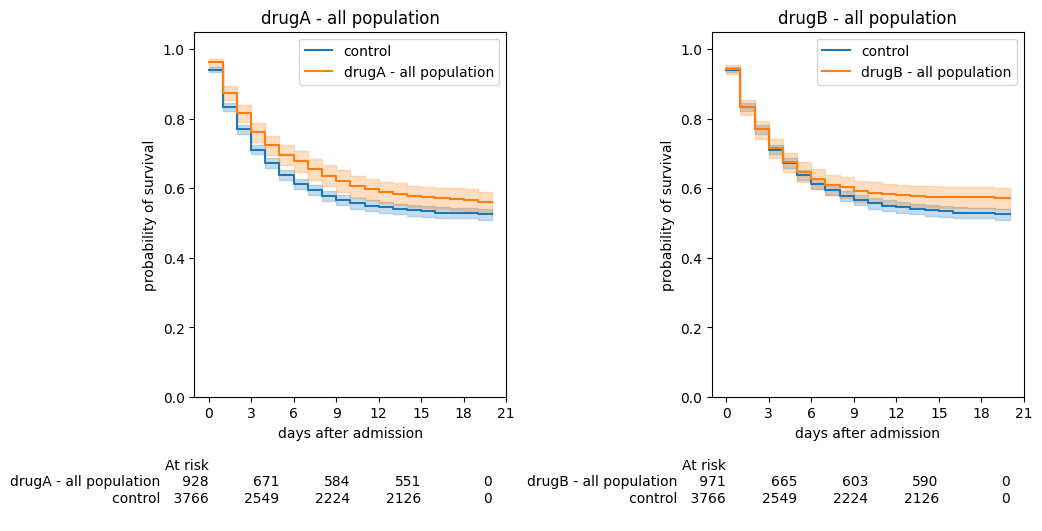

In [166]:
plot_primary_kaplan(df_person, [(df_visit, df_med, 'all population')], t_end_of_study)

What can be concluded on the effect of each drugs?

**Correction** :
<br> It seems that drugA has a positive impact on the survival of the patients.
<br> but that drugB doesn't.

## 3.2 Using the NLP extraction algorithm

Plot the  primary Kaplan-Meier estimates for the whole `df_note_annotated_grouped` dataFrame

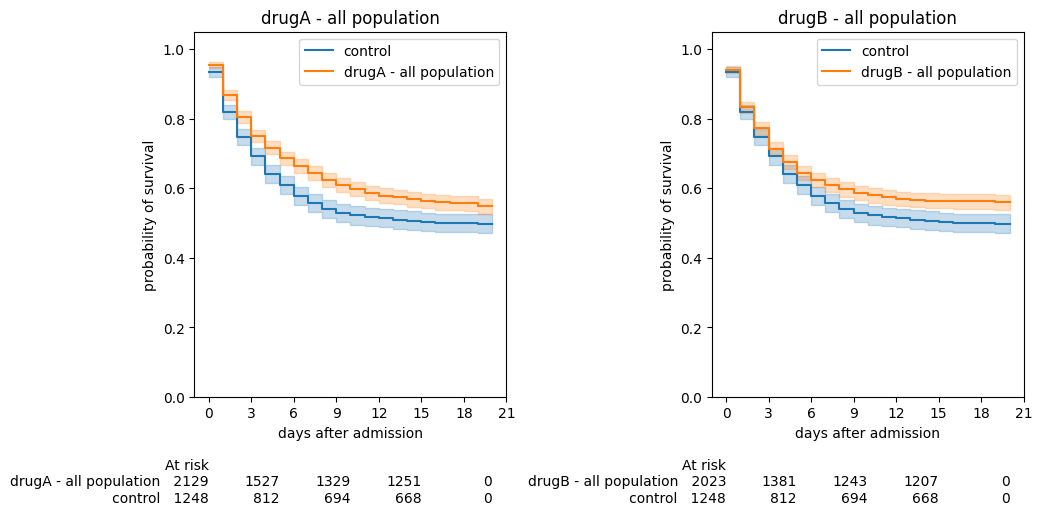

In [156]:
plot_primary_kaplan(df_person, [(df_visit, df_note_annotated_grouped, 'all population')], t_end_of_study)

In this exercise we have illustrated some challenges related to handling clinical notes when conducting a study using real-world data. We have shown that different approaches may be adopted and compared.

# 4. Takeaways

- **Clinical notes** are unstructured data that contain numerous pieces of information but that are challenging to analyze. Specific pre-processing pipelines should be developed, validated and deployed to extract structured variables out of unstructured texts (**Natural Language Processing** algorithms - NLP).
- Natural Language processing algorithms rely either on a **rule-based approach** or on a **machine learning approach**. Here we implemented only the rule-based approach, which is technically simpler than machine learning approaches, but require a strong contribution from expert clinicians to handcraft rules. Both approaches have their pros and cons and they may be compared on some specific tasks.
- A single variable used at the statistical analysis stage may be **defined leveraging various sources of data**, either structured or unstructured. The methodology used to define each variable may impact the result of the statistical analysis, and it should consequently be discussed.

# 5. References

- Honnibal, Matthew, Ines Montani, Matthew Honnibal, Henning Peters, Sofie Van Landeghem, Maxim Samsonov, Jim Geovedi, et al. explosion/spaCy: v2.1.7: Improved evaluation, better language factories and bug fixes. Zenodo, 2019. https://doi.org/10.5281/zenodo.3358113.
- Aronow, D. B., F. Fangfang, et W. B. Croft. « Ad Hoc Classification of Radiology Reports ». Journal of the American Medical Informatics Association 6, nᵒ 5 (1 septembre 1999): 393‑411. https://doi.org/10.1136/jamia.1999.0060393.
- Garcelon, Nicolas, Antoine Neuraz, Vincent Benoit, Rémi Salomon, et Anita Burgun. « Improving a Full-Text Search Engine: The Importance of Negation Detection and Family History Context to Identify Cases in a Biomedical Data Warehouse ». Journal of the American Medical Informatics Association, 20 octobre 2016, ocw144. https://doi.org/10.1093/jamia/ocw144.
- Jouffroy, Jordan, Sarah F Feldman, Ivan Lerner, Bastien Rance, Anita Burgun, et Antoine Neuraz. « Hybrid Deep Learning for Medication-Related Information Extraction From Clinical Texts in French: MedExt Algorithm Development Study ». JMIR Medical Informatics 9, nᵒ 3 (16 mars 2021): e17934. https://doi.org/10.2196/17934.
- Névéol, Aurélie, Hercules Dalianis, Sumithra Velupillai, Guergana Savova, et Pierre Zweigenbaum. « Clinical Natural Language Processing in Languages Other than English: Opportunities and Challenges ». Journal of Biomedical Semantics 9, nᵒ 1 (décembre 2018): 12. https://doi.org/10.1186/s13326-018-0179-8.